# Projet IoT

## Nom : Kaub
## Prenom : Jacky
## Mail : jacky.kaub@telecom-paristech.fr

# Import des fonctions utiles

Ci-dessous, quelques fonctions que j'ai codé qui m'ont servi pour le projet

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from geopy.distance import vincenty
import seaborn as sns
import random

def filter_by_nbs(df):
    
    """return a dict of messages associated with the number of borns that saw it"""
    u=df_mess_train.groupby("messid").count()
    L = u.index
    num = [u['bsid'][l] for l in L]
    x=[(a[0],a[1]) for a in zip(L,num)]
    x.sort(key=lambda x:x[1],reverse=True)
    return x

def dist(lat1,lat2,lng1,lng2):
    """Calcul de la distance pour un point donnée, connaissant les lats et lng
    lat1/lat2/lng1/lng2 : float
    """
    #On calcul la distance entre chaque point du mesh et chaque station
    a=(np.sin((lat1-lat2)/2*np.pi/180)**2
    +np.cos(lat1*np.pi/180)
   *np.cos(lat2*np.pi/180)
   *(np.sin((lng1-lng2)/2*np.pi/180))**2)

    c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return 6371*c

def rescale_all_rssi(X):
    for did in list_of_did:
        rescale_rssi_by_did(X,did)
        
        
def plot_distrib(df, dist, rssi, lenx=5,leny=10,shade=True,adj=1):
    """Renvoie la distribution des données
    
    lenx = taille de la maille en abscisse pour les probas
    leny = taille de la maille en ordonnée pour les probas"""
    
    
    #paramètres du maillage
    if shade==True:
        xini = df[dist].min() 
        xmax = df[dist].max()
        yini = df[rssi].min()
        ymax = df[rssi].max()
        deltx = (xmax-xini)/lenx
        delty = (ymax-yini)/leny

        for i in range(lenx):
            for j in range(leny):
                df_w=df[(df[dist]>=xini+i*deltx) & (df[dist]<xini+(i+1)*deltx)].copy()
                df_w=df_w[(df_w[rssi]>=yini+j*delty) & (df_w["rssi"]<yini+(j+1)*delty)]
                sh = len(df_w)/len(df)*adj
                c = pl.cm.hot(sh)
                plt.scatter(df_w[dist],df_w[rssi],c=c)
        plt.title(f"{rssi} en fonction de {dist}")
        plt.xlabel(dist)
        plt.ylabel(rssi)
    else:
        plt.scatter(df[dist],df[rssi],c="r")
        
def plot_circle(Xc,Yc,r,mesh = 10):
    Xr = np.array(range(11))/10*np.pi*2
    plt.plot(Xc+np.cos(Xr)*r/100,Yc+np.sin(Xr)*r/80)


# Introduction

Le but de ce TP est de prédire avec un maximum de précision les coordonnées (LAT et LNG) d'un device électronique (DID) à un instant donnée lorsqu'il emet un message (MESSID). 

Ces messages sont captés par les stations relais (BS). Ces stations, dont nous connaissons les coordonnées (BSLAT/BSLNG) captent également la puissance des messages (RSSI), ainsi qu'un numéro de séquence (NSEQ).

Il est théoriquement possible de remonté à la distance entre le DID et la BSID en connaissant le RSSI et remonter à la position du DID par triangularisation. Néanmoins, la mesure du RSSI est très peu précise est beaucoup d'éléments peuvent interférer sur la puissance de réception au niveau du récepteur (BS) (par exemple : obstacle sur la route, conditions météos, qualité du capteur inférieur, etc...).

Nous allons essayer d'exploiter les informations à notre disposition afin de faire la meilleure prédiction possible.

Toutes les fonctions utilisés dans ce TP sont stockés dans un fichier .py annexe.

# Chargement des données / Exploration des données

### Exploration global 

In [2]:
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

print(f"Nombres d'entrées dans mess_train_list : {len(df_mess_train)}")
print(f"Nombres d'entrées dans mess_test_list : {len(df_mess_test)}")
print('\n')
print(f"Nombres de messages uniques dans mess_train_list : {len(df_mess_train.messid.unique())}")
print(f"Nombres de messages uniques dans mess_test_list : {len(df_mess_test.messid.unique())}")
print('\n--------------------------------------------')
print(df_mess_train.head())
print('\n--------------------------------------------')
print(pos_train.head())

Nombres d'entrées dans mess_train_list : 39250
Nombres d'entrées dans mess_test_list : 29286


Nombres de messages uniques dans mess_train_list : 6068
Nombres de messages uniques dans mess_test_list : 5294

--------------------------------------------
                     messid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216  

--------------------------------------------
         lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.95

Les datas sont donc stockés dans mess_train_list, et les variables à prédire dans pos_train.

Chaque ligne de  mess_train_list correspond à un couple (MESSID / BSID) et plusieurs lignes peuvent avoir le même MESSID. C'est logique car un message émis peut être capté par plusieurs stations BSID avec une puissance RSSI différente. C'est cette information que nous essayerons de mettre le plus en valeur par la suite.

Chaque ligne de pos_train correspond à la ligne équivalente dans mess_train_list.

### Différences entre train et test sets 

##### Différences sur les BS

In [3]:
set1 = set(df_mess_train["bsid"].unique())
set2 = set(df_mess_test["bsid"].unique())

print(f"nombre de bsid dans le set1 : {len(set1)}")
print(f"nombre de bsid dans le set2 : {len(set2)}")

sameset = set2.intersection(set1)
print(f"il y a {len(set2)-len(sameset)} BS uniques dans le set train sur {len(set2)}")

nombre de bsid dans le set1 : 251
nombre de bsid dans le set2 : 168
il y a 8 BS uniques dans le set train sur 168


Globalement, il y a seulement 8 BS dans le test set qui n'apparaissent pas dans le train set (moins de 5% des BS du test set). Nous pouvons donc raisonnablement faire du feature engineering sur les BS du train set en se basant sur toutes les informations à disposition (incluant 'lat'/'lng') afin de raffiner les informations à disposition lorsque l'on fera nos prédictions sur le test set

##### Différences sur les DID# 

In [4]:
set1 = set(df_mess_train["did"].unique())
set2 = set(df_mess_test["did"].unique())

print(f"nombre de DEVICES dans le set1 : {len(set1)}")
print(f"nombre de DEVICES dans le set2 : {len(set2)}")

sameset = set2.intersection(set1)
print(f"il y a {len(set2)-len(sameset)} DEVICES uniques dans le set train sur {len(set2)}")

nombre de DEVICES dans le set1 : 113
nombre de DEVICES dans le set2 : 56
il y a 56 DEVICES uniques dans le set train sur 56


On voit en revanche qu'aucun DID du test set n'est présent dans le train set. Cela va avoir deux impacts pour nous :
- Il faudra faire attention au feature engineering que l'on va faire sur DID afin de ne pas biaiser le train set.
- Lors de nos cross-validations, on prendra soin d'avoir un validation set avec des devices différents de celui du train set pour avoir un résultat similaire à ce que l'on pourra avoir sur le test set.

### Exploration des données train

Par commodité, on merge les variables à prédire de "pos_train" et les variables explicatives dans un seul et même dataset.

De même, on peut convertir "time_ux" dans un format plus lisible et ajouté une colonne "distance_bs_mess" calculé en fonction des coordonnées des BS et des MESSID pour chaque ligne du dataset.

Les distances sont exprimées en mètres et arrondis au mètre près.

In [5]:
df = df_mess_train.join(pos_train)
df['distance_bs_mess'] = np.round(dist(df.lat.values,df.bs_lat.values,df.lng.values,df.bs_lng.values),3)
df['time_ux'] =  pd.to_datetime(df.time_ux.values,unit='ms')
df.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance_bs_mess
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,2016-05-18 04:38:49,39.617794,-104.954917,39.606690,-104.958490,1.272
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,2016-05-18 04:38:49,39.677251,-104.952721,39.606690,-104.958490,7.862
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,2016-05-18 04:45:07,39.612745,-105.008827,39.637741,-104.958554,5.125
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,2016-05-18 06:33:52,39.797969,-105.073460,39.730417,-104.968940,11.672
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,2016-05-18 06:33:52,39.723151,-104.956216,39.730417,-104.968940,1.355


##### Lien entre RSSI et distance relative

Comme mentionné en introduction, il existe normalement un lien entre RSSI et distance relative. Nous pouvons visualiser ce lien en affichant sur un graphique RSSI en fonction de distance.

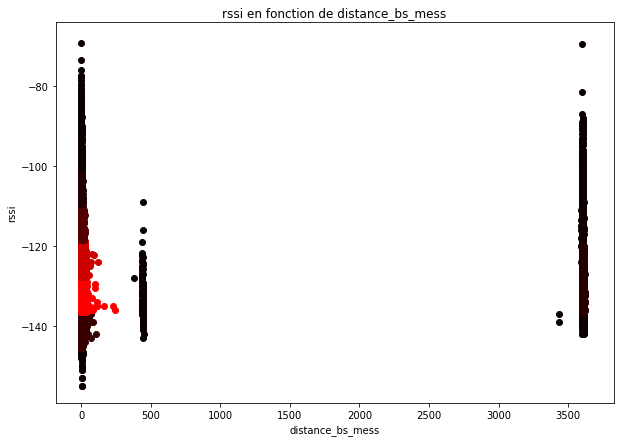

In [6]:
lenx = 10
leny = 10
#On plot les données non-modifiées
plt.figure(figsize=(10,7))
plot_distrib(df, "distance_bs_mess", "rssi", lenx,leny)

Visuellement, on constate un problème : certains stations sont situés à plus de 500 km des messages captés, ce qui n'est physiquement pas possible ! Il y a donc un problème de données, soit sur la position des BS, soit sur la position du MESSID.

Nous fixerons ce problème dans la partie "feature engineering", pour le moment, afin de visualiser correctement les données, nous pouvons simplement supprimer les données abérantes du dataset.

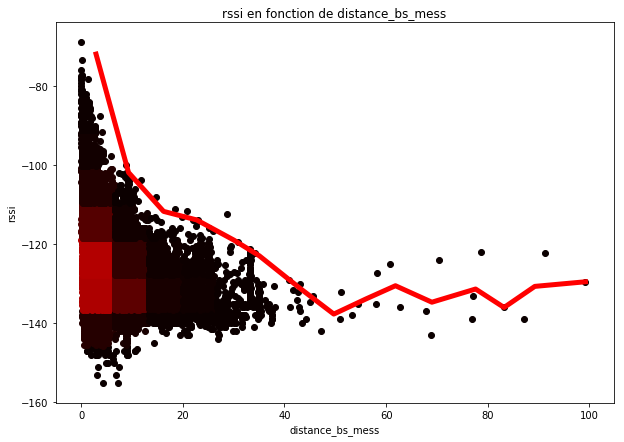

In [7]:
lenx = 15
df_sub = df[df.distance_bs_mess < 100]
xini = df_sub["distance_bs_mess"].min()
xmax = df_sub["distance_bs_mess"].max()
deltx = (xmax-xini)/lenx

R = []
d = []
for j in range(lenx):
    R.append(df_sub[(df_sub["distance_bs_mess"]>xini+j*deltx) & (df_sub["distance_bs_mess"]<xini+(j+1)*deltx)]
             .sort_values("rssi",ascending = False).head(5)["rssi"].mean())
    d.append(df_sub[(df_sub["distance_bs_mess"]>xini+j*deltx) & (df_sub["distance_bs_mess"]<xini+(j+1)*deltx)]["distance_bs_mess"].mean())

plt.figure(figsize=(10,7))    
plot_distrib(df_sub, "distance_bs_mess", "rssi", lenx,leny)
plt.plot(d,R,c="r",linewidth=5)

Ce dernier graph est déjà plus parlant, et on voit se dessiner la loi de decroissance exponentielle entre le rssi et distance. (visualisé par la courbe en rouge)

Cette courbe reflète la distance maximum à laquel un MESSID peut se trouver en connaissant le RSSI capté par la BS.

Néanmoins, et de manière prévisible, la plupart des RSSI on un RSSI plus faible que ce à quoi on s'attendrait dans le cas idéal matérialisé par la courbe rouge à cause des facteurs extérieurs expliqués en introduction.


##### Position spaciale des BS et des MESSID

Afin de savoir si les abérations dans les données viennent des MESSID ou des BSID, nous pouvons afficher les positions respectives des BSID et des DID en utilisant leurs coordonnées.

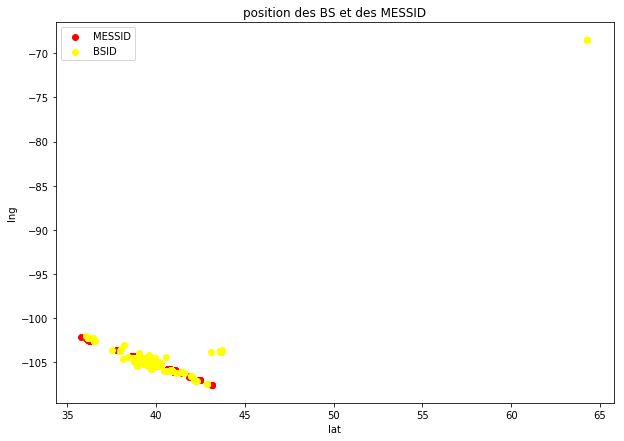

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(df.lat,df.lng, color = 'red')
plt.scatter(df.bs_lat,df.bs_lng, color = 'yellow')
plt.title('position des BS et des MESSID')
plt.xlabel('lat')
plt.ylabel('lng')
plt.legend(['MESSID','BSID'])

Visuellement, on voit plusieurs outsiders du coté des BSID, et il sagit sans doute de données corrompues. Nous devons prendre soin de modifier la position de ces BSID lorsque nous ferons nos prédictions.

Pour le moment, nous visualisons à nouveau le même graphe en prenant soin de retirer les outsiders.

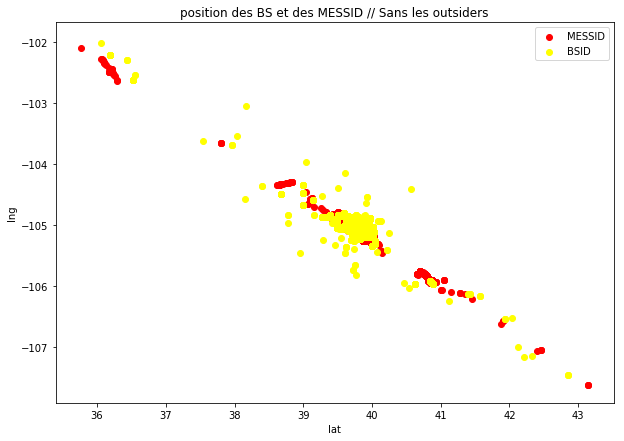

In [9]:
df_sub = df[df.distance_bs_mess <300]

plt.figure(figsize=(10,7))
plt.scatter(df_sub.lat,df_sub.lng, color = 'red')
plt.scatter(df_sub.bs_lat,df_sub.bs_lng, color = 'yellow')
plt.title('position des BS et des MESSID // Sans les outsiders')
plt.xlabel('lat')
plt.ylabel('lng')
plt.legend(['MESSID','BSID'])

On voit qu'une fois les outliners supprimés, la répartition entre les MESSID et les BSID est bien plus cohérente.
Il faut tout de même vérifier si nous avons le droit de faire cela. On regarde combien de MESSID sont impactés par ces BSID 'outliners'

In [10]:
#On filtre les outliners par la distance
df_ = df[df.distance_bs_mess > 300]

#On creer la liste des messages pour lesquelles il y a au moins un outliner
mess_outliners = df_.messid.unique()
print(f'il y a {round(len(mess_outliners)/len(df.messid.unique())*100)} % des messages impactés par au moins un outliner')

#On regarde également le nombre de BS captant ces messages impactés par au moins 1 outliners
df_ = df[df.messid.isin(mess_outliners)]
df_ = df_[['messid','bsid']].rename(columns = {'bsid': 'count_bsid'}).groupby('messid').count().sort_values('count_bsid')
df_['tot_%_mess'] = range(len(df_))
df_ = round(df_.groupby('count_bsid').count()/len(df.messid.unique())*100,1)

df_.head(5)

il y a 31 % des messages impactés par au moins un outliner


,tot_%_mess
count_bsid,
1,2.3
2,2.2
3,2.4
4,2.4
5,2.6


Ce que nous montre le tableau ci-dessus, c'est que plus de 10% des messages du dataset sont : 
- vu par moins de 5 stations au total
- vu par au moins une station defectueuse

Si l'on décide de purement supprimer ces stations defectueuses, nous aurons une grande perte d'information pour ces messages, il faudra donc trouver un moyen de corriger la position de ces BSID

#### Visualisation d'un cas de figure MESSID / BSID 

On s'intéresse maintenant à un MESSID donnée, on va pouvoir afficher toutes les BSID qui sont activés par l'emission de ce MESSID, et celles qui ne le sont pas

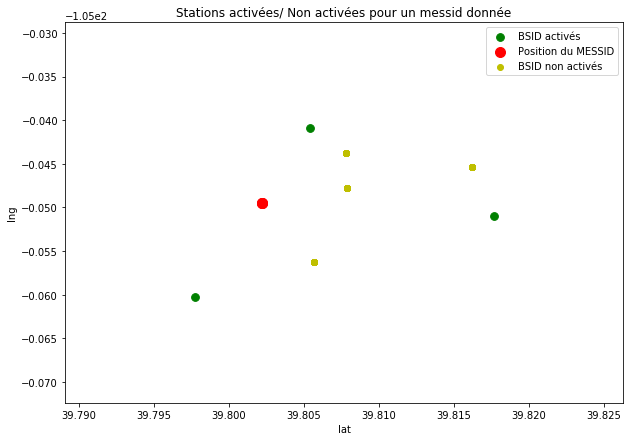

In [12]:
#On creer une liste des messid unique
messid_unique = df.messid.unique()
#On tire au sort un messid dans la liste
n = random.randint(0,len(messid_unique))
mess = messid_unique[n]

df_ = df_sub.loc[df_sub.messid == mess,['bsid','lat','lng','bs_lat','bs_lng']]

mess_lat = df_.lat.unique()[0]
mess_lng = df_.lng.unique()[0]

#On plot la position de notre message et des stations activés
plt.figure(figsize=(10,7))
plt.scatter(df_.bs_lat,df_.bs_lng, color='green',s=60)
plt.scatter(df_.lat,df_.lng, color='red', s=100)

#On garde en memoire la liste des bs actionnées
bs_active = df_.bsid.unique()

#On cherche la station active la plus éloigné au message
dist_max = dist(mess_lat,df_.bs_lat.values,mess_lng,df_.bs_lng.values).max()

#On creer un nouveau df pour lequel on va calculer la distance relative à la position du message
df_ = df_sub.copy()
df_['dist_mess'] = dist(mess_lat,df_.bs_lat.values,mess_lng,df_.bs_lng.values)

#On ne conserve que les stations dans un périmètre proche
p = dist_max
df_ = df_[df_.dist_mess < p]
df_ =  df_[~df_.bsid.isin(bs_active)]
#On plot les stations proches du message qui ne s'activent pas
plt.scatter(df_.bs_lat,df_.bs_lng, color='y')
plt.title('Stations activées/ Non activées pour un messid donnée')
plt.xlabel('lat')
plt.ylabel('lng')
plt.legend(['BSID activés','Position du MESSID','BSID non activés'])

On constate donc que toutes les stations à proximité d'un device ne s'active pas lorsque celui-ci emet un message. 
Je me pose donc la question suivante : pour des messages 'proches' émis par un même DID, est-ce que ce sont les mêmes stations qui s'activent et qui ne s'activent pas ?

# Approche 1 : Triangularisation par distance prédite via ML

Dans cette partie je vais essayer plusieurs méthodes de feature engineering couplés à plusieurs algorithmes de machine learning. 

Afin de valider chaque modèle, une cross-validation sera réalisée sur l'ensemble du training set en prenant soin de séparer les devices entre le training set et le validation set. 

La métrique utilisé pour valider les modèles sera la distance entre prediction et position réelle et plus précisement le quantile 0.8.

## Repositionnement des BS défaillantes 

Afin de repositionner simplement les BS défaillantes, j'utilise une approche simple qui consiste à regarder la position moyenne des autres stations voyant un message, et de remoyenner pour chaque message vu par la station defectueuse. J'utilise pour cela la fonction ci-dessous.

In [13]:
def cleaning_bs(X,distance,d=100):
    #On repère toutes les stattions défaillantes, on considère dans un premier temps toutes les stations au dela de 100km
    defX = X[X[distance]>d].sort_values(distance)

    print(f"nombre de stations défaillantes : {len(defX['bsid'].unique())}")

    def_bsid = defX['bsid'].unique()

    #Approche simple : si des stations non-defectueuses sont à proximité, on ajoute la station défectueuse
    #au même endroit que la station non-defectueuse la plus proche

    for k in range(2):
        for bsid0 in def_bsid:
            messDef = X[X['bsid']==bsid0]["messid"]
            df_bsid = X[X["messid"].isin(messDef)]
            df_bsid = df_bsid[(1-df_bsid["bsid"].isin(def_bsid)).apply(lambda x: True if x==1 else False)]
            if len(df_bsid) != 0:
                #On va chercher à récupérer la borne la plus proche du RSSI pour chaque message, et moyenner les positions
                mess = df_bsid["messid"].unique()
                lat = []
                lng = []
                for m in mess:
                    df_bsid_fil = df_bsid[df_bsid["messid"]==m][["bsid","rssi",distance,"bs_lat","bs_lng"]].copy()
                    df_bsid_fil["rssir"]=np.floor(df_bsid_fil["rssi"]/5)*5
                    bad_rssi = X[(X["bsid"]==bsid0) & (X["messid"]==m)]["rssi"]
                    bad_rssi = np.floor(bad_rssi/5)*5
                    lat.append(df_bsid_fil["bs_lat"].mean())
                    lng.append(df_bsid_fil["bs_lng"].mean())
                if len(lat):
                    lat = sum(lat) / float(len(lat))
                if len(lng):
                    lng = sum(lng) / float(len(lng))
                    X.loc[X['bsid'] == bsid0, 'bs_lat'] = lat
                    X.loc[X['bsid'] == bsid0, 'bs_lng'] = lng

        X[distance] = dist(X.lat,X.bs_lat,X.lng,X.bs_lng)
        defX = X[X[distance]>d].sort_values(distance)
        print(f"nombre de stations défaillantes : {len(defX['bsid'].unique())}")
        dd = defX.loc[defX["bsid"].drop_duplicates().index]
        def_bsid = dd["bsid"].unique()
        X=X.drop(X[X["bsid"].isin(def_bsid)].index)
    return X

In [14]:
df = cleaning_bs(df, 'distance_bs_mess', d = 200)

nombre de stations défaillantes : 39
nombre de stations défaillantes : 11
nombre de stations défaillantes : 0


### Feature Engineering 

In [14]:
df_ = df.copy()

#Nombre de BS total qui voient un message donné
_ = df[['messid','bsid']].groupby('messid').apply(lambda x: len(list(x['bsid'])))
_ = df.join(pd.DataFrame(_).rename(columns={0:'_'}), on ='messid')
df_['num_bs'] = _['_']

#Nombre de MESSID total vu par chaque BS
_ = df[['messid','bsid']].groupby('bsid').apply(lambda x: len(list(x['messid'])))
_ = df.join(pd.DataFrame(_).rename(columns={0:'_'}), on='bsid')
df_['num_mess'] = _['_']

#RSSI moyen capté par une BSID donnée
df_['mean_bs_rssi'] = df.join(df[['bsid','rssi']].groupby('bsid').mean().rename(columns={"rssi":'_'}), on = 'bsid')['_']

#NSEQ moyen capté par une BSID donnée
df_['mean_nseq'] = df.join(df[['bsid','nseq']].groupby('bsid').mean().rename(columns={"nseq":'_'}), on = 'bsid')['_']

#RSSI moyen d'un MESSID donnée
df_['mean_mess_rssi'] = df.join(df[['messid','rssi']].groupby('messid').mean().rename(columns={"rssi":'_'}), on = 'messid')['_']

#RSSI moyen d'un DID
df_['mean_did_rssi'] = df.join(df[['did','rssi']].groupby('did').mean().rename(columns={"rssi":'_'}), on = 'did')['_']

#Nombre de BS captés par un DID
_ = df[['bsid','did']].groupby('did').apply(lambda x: len(list(x['bsid'])))
_ = pd.DataFrame(_).rename(columns={0:'_'})
df_['num_bs_by_did'] = df.join(_,on = 'did')['_']

#Distance maximal entre 2 BS, pour un MESSID donné
_ = df[['bs_lat','bs_lng','messid']].groupby('messid').max().rename(columns={'bs_lat':'max_lat','bs_lng':'max_lng'})
_ = _.join(df[['bs_lat','bs_lng','messid']].groupby('messid').min().rename(columns={'bs_lat':'min_lat','bs_lng':'min_lng'}))
_['bs_dist_max'] = dist(_.max_lat.values,_.min_lat.values,_.max_lng.values,_.min_lng.values)
df_['bs_dist_max'] = df.join(_.bs_dist_max, on='messid')['bs_dist_max']

#Jour de la semaine / Heure / Mois de l'année
df_['weekday'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.weekday
df_['hour'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.hour
df_['month'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.month

#On supprime les features qui ne seront pas utiles pour les prévisions 
df_ = df_.drop(['messid','time_ux','lat','lng','distance_bs_mess'], axis=1)

### Entrainement du modèle

Pour entrainer le modèle, j'ai crée une fonction spécial qui va réalisé un cross-val en séparant les DID entre train et test, et qui merge les résultats finaux. Je peux passer l'algorithme de prédiction que je veux utiliser dedans.

A noter : en choisissant folds = len(did) : on réaliser un crossval one-device-out. Je me suis limité à une crossval à 10 devices-folds pour des raisons de puissance de calcul.

In [15]:
def did_cross_val(X,X_,list_unique, folds,model,pred):
    
    """Retourne une dataframe des prédictions en pratiquant une crossval sur les data"""
    __X = X_
    list_f = list(list_unique.copy())
    
    #On mélange les device
    np.random.shuffle(list_f)
    
    #On prépare le nombre de folds pour le kfold
    k = int(np.floor(len(list_f)/folds))
    fold_l = []
    ###On creer les listes pour le crossval
    for i in range(folds-1):
        fold_l.append(list_f[i*k:((i+1)*k)])
    fold_l.append(list_f[((i+1)*k):])
    
    DF = []
    #On creer les variables de test et train :
    for did_l in fold_l:
        df = pd.DataFrame()
        
        #On train sur dist
        mod = model
        pred = pred
        
        #On rajoute la variable à prévoir à notre database
        _X = __X
        _X[pred] = X[pred]
        
        #On selectionne les lignes pour les devices selectionnées
        X_train = _X[~_X[('did')].isin(did_l)].drop([pred,"did"],axis=1).copy()
        X_test = _X[_X['did'].isin(did_l)].drop([pred,"did"],axis=1).copy()
        y_train = _X[~_X['did'].isin(did_l)][pred].values.ravel()
        y_test = _X[_X['did'].isin(did_l)][pred].values.ravel()
        
        #On entraine le model et on prédit sur le test set
        mod.fit(X_train,y_train)
        ypred = mod.predict(X_test)
        
        df['p'+pred] = ypred
        
        #On ajoute l'indexe
        df['ind'] =  _X[_X['did'].isin(did_l)].index
        df = df.set_index('ind')
        DF.append(df)
        
    return pd.concat(DF)

### Utilisation de LightGBM pour estimer la distance entre BS et MESSID

J'ai essayé plusieurs algorithmes pour prédire la distance, c'est LGBM qui m'a donné les meilleurs résultats en crossvalidation sur les prédictions de distance entre BSID et MESSID

LightGBM est un algorithm de boosting dans la même ligné que XGBoost et GradientBoost développé par Microsoft en 2017. Il utilise un développement vertical des arbres de décision pour minimiser l'erreur

In [16]:
from lightgbm import LGBMRegressor

list_did = df.did.unique()
model = LGBMRegressor(num_leaves = 300, n_estimators=300, max_depth = 10, reg_lambda = 1)
ypred =  did_cross_val(df,df_,list_did, 10,model,'distance_bs_mess')
ypred['dist'] = df['distance_bs_mess']
ypred['err'] = np.abs(ypred.dist-ypred.pdistance_bs_mess)

In [17]:
ypred.head()

,pdistance_bs_mess,dist,err
ind,,,
147,5.694236,1.849749,3.844488
148,8.337663,2.707648,5.630015
149,5.086008,1.979577,3.106431
150,13.106713,11.693261,1.413452
151,5.054314,0.836618,4.217696


### Utilisation d'un algorithme de triangularisation pour prédire lat et lng 

Maintenant que nous avons une estimation de la distance, nous pouvons tenter de prédire la position exacte du device par triangularisation :

Pour chaque message :
- On trace le cercle de rayon prédit et de centre BSID. Pour se faire on définit un maillage de point de valeur 1. Si un point est situé en dehors du cercle, on donne la valeur 0 à ce point. Les points à l'intersection de tous les cercles gardent la valeur 1
- On prend la moyenne de la surface en intersection entre tous les cercles pour prédire la position de DID
- Si les cercles n'ont pas d'intercection, on augmente progressivement le diamètre
- Si l'augmentation de diamètre ne suffit pas, on se contente de prendre la position moyenne entre toutes les BSID activées par le MESSID

Ci-dessous le code de l'algorithme :

In [18]:
def scores(dist1,dist2):
    if dist1 < dist2:
        return 1
    else :
        return 0
    
scores = np.vectorize(scores)

def n_est(X,m,mesh,p=0):
    #On s'intéresse à un message m, on isole toutes les lignes correspondant à ce message
    df = X.loc[X.messid == m].sort_values('rssi', ascending = False).head(15)

    #On se base sur les BS pour définir le maillage
    Zx = df["bs_lat"].min()-0.2
    Zxx = df["bs_lat"].max()+0.2
    Zy = df["bs_lng"].min()-0.2
    Zyy = df["bs_lng"].max()+0.2

    #On génère un dataframe pour le maillage
    lat = pd.DataFrame()
    lat["mesh_lat"] = np.arange(Zx, Zxx, abs(Zx-Zxx)/mesh/1.5)
    lng = pd.DataFrame()
    lng["mesh_lng"] = np.arange(Zy, Zyy, abs(Zy-Zyy)/mesh)
    lat['key'] = 0
    lng['key'] = 0
    mesh = lat.merge(lng, how='left', on = 'key')
    mesh['tot'] = np.ones(len(mesh))
    #On calcul la distance entre chaque point du maillage et les BS
    for j in range(len(df)):
        mesh[f"dist_{j}"] = dist(mesh["mesh_lat"].values,df.iloc[j]["bs_lat"],mesh["mesh_lng"].values,df.iloc[j]["bs_lng"])
        mesh[f'score_{j}'] = scores(mesh[f'dist_{j}'],df.iloc[j]['pred_dist']+0.5)
        mesh['tot'] = mesh['tot']*mesh[f'score_{j}']

    p_mesh = mesh.loc[mesh.tot == 1,["mesh_lat","mesh_lng"]]
    #On garde tous les points à l'intérieur de la zone de prédiction
    pred_mesh = mesh.loc[mesh.tot == 1,["mesh_lat","mesh_lng"]].mean()

    
    eps = 1
    while len(p_mesh)==0:
        mesh['tot'] = np.ones(len(mesh))
        for j in range(len(df)):
            mesh[f"dist_{j}"] = dist(mesh["mesh_lat"].values,df.iloc[j]["bs_lat"],mesh["mesh_lng"].values,df.iloc[j]["bs_lng"])
            mesh[f'score_{j}'] = scores(mesh[f'dist_{j}'],df.iloc[j]['pred_dist']+0.5+eps)
            mesh['tot'] = mesh['tot']*mesh[f'score_{j}']
        p_mesh = mesh.loc[mesh.tot == 1,["mesh_lat","mesh_lng"]]
        #On garde tous les points à l'intérieur de la zone de prédiction
        pred_mesh = mesh.loc[mesh.tot == 1,["mesh_lat","mesh_lng"]].mean()
        eps +=1
        if eps > 5:
            break
          
    #Si aucun point n'est prédit, ou si au contraire trop de points sont dans l'ensemble, on utilise la prédiction classique
    ####A coder
    if len(p_mesh)==0:
        pred_mesh = df[['bs_lat','bs_lng']]
        pred_mesh = pred_mesh.rename(index = int, columns = {'bs_lat':"mesh_lat",'bs_lng':"mesh_lng"}).mean()

    if p == 1 :
        plt.figure(figsize=(10,7))
        plt.title('Visualisation of the prediction by triangularisation')
        plt.xlabel('lat')
        plt.ylabel('lng')
        plt.scatter(p_mesh.mesh_lat,p_mesh.mesh_lng,c='yellow', label = 'mesh inside all circles')
        plt.scatter(df.bs_lat,df.bs_lng,c='black', label = 'stations')
        plt.scatter(df.lat,df.lng,c='green', label = 'true position')
        plt.scatter(pred_mesh.mesh_lat,pred_mesh.mesh_lng,c='red', label='prediction')
        plt.legend()

        for j in range(len(df)):
            plot_circle(df.iloc[j]["bs_lat"],df.iloc[j]["bs_lng"],df.iloc[j]["pred_dist"],mesh = 10)
        print(f'err : {round(dist(df.lat.mean(),pred_mesh.mesh_lat,df.lng.mean(),pred_mesh.mesh_lng),3)} km')
    return [m,pred_mesh[0],pred_mesh[1]]



On applique l'algorithme au dessus à notre problème :

In [19]:
mesh = 40
df['pred_dist'] = ypred.pdistance_bs_mess
mess = df.messid.unique()
k = random.randint(0,len(mess))
err = []
k=1
for m in mess:
    err.append(n_est(df,m,mesh,p=0))
    if len(err) % 300 == 0:
        print(f'{k*5}% done!')
        k+=1
        
pred_df = pd.DataFrame(err, columns = ['messid','p_lat','p_lng']).dropna()
pred_df = pred_df.merge(df[['lat','lng','messid']].drop_duplicates(), on = 'messid')
pred_df['dist'] = dist(pred_df.lat.values,pred_df.p_lat.values,pred_df.lng.values,pred_df.p_lng.values)

print(f'Erreur commise au quantile 0.8 : {round(pred_df["dist"].quantile(0.8),3)} km')

5% done!
10% done!
15% done!
20% done!
25% done!
30% done!
35% done!
40% done!
45% done!
50% done!
55% done!
60% done!
65% done!
70% done!
75% done!
80% done!
85% done!
90% done!
95% done!
100% done!
Erreur commise au quantile 0.8 : 4.889 km


### Erreur Cumulative

On peut représenter l'erreur cumulative de notre modèle sur le graphique ci-dessous

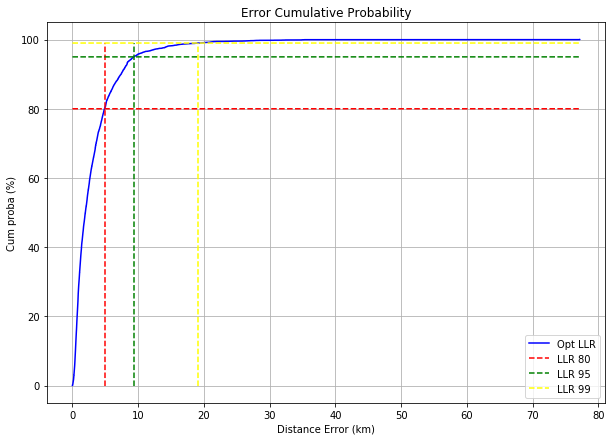

In [20]:
values, base = np.histogram(pred_df['dist'], bins=50000)
cumulative = np.cumsum(values) 
plt.figure(figsize=(10,7));
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue', label = 'Opt LLR')
plt.plot(base[:-1],np.ones(len(base[:-1]))*80,color = 'red', linestyle = '--', label = 'LLR 80')
plt.plot(np.ones(100)*pred_df["dist"].quantile(0.8),range(100),color = 'red', linestyle = '--')
plt.plot(base[:-1],np.ones(len(base[:-1]))*95,color = 'green', linestyle = '--', label = 'LLR 95')
plt.plot(np.ones(100)*pred_df["dist"].quantile(0.95),range(100),color = 'green', linestyle = '--')
plt.plot(base[:-1],np.ones(len(base[:-1]))*99,color = 'yellow', linestyle = '--', label = 'LLR 99')
plt.plot(np.ones(100)*pred_df["dist"].quantile(0.99),range(100),color = 'yellow', linestyle = '--')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)');  
plt.title('Error Cumulative Probability'); plt.legend()
plt.show()

J'ai également mis en place un petit outil de visualisation dans ma fonction de prédiction qui permet de voir comment fonctionne ma triangularisation.

err : 1.291 km


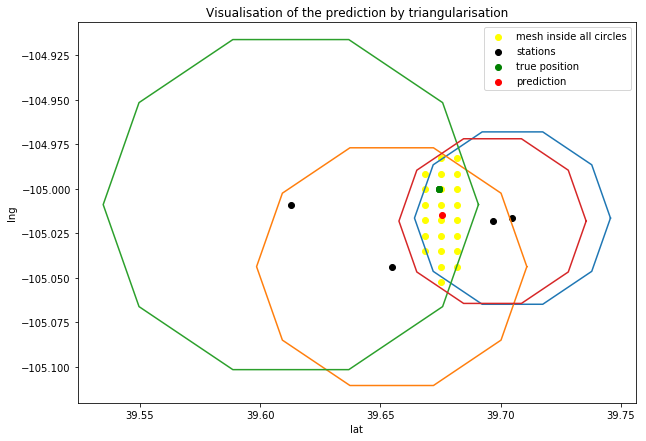

In [21]:
mesh=50
mess = df.messid.unique()
i = random.randint(0,len(mess))
m = mess[i]
pred = n_est(df,m,mesh,p=1)

# Conclusion

J'avais tout d'abord essayé d'utiliser des algorithmes de machine pure pour prédire latitude et longitude, mais sans résultats intéressants (Mon erreur cumulative à 80% s'élevait à, au mieux, 6.5km). Je me suis donc tourné vers cette approche intermédiaire entre Machine Learning et Triangularisation qui améliore nettement les résultats.

Mon approche de triangularisation est très sensible à la distance prédite dans la partie machine learning, aussi, si j'avais eu plus de temps, j'aurais sans doute essayé d'affiner mon modèle en utilisant par exemple des réseaux de neuronnes et de l'embedding sur les données catégoriques.

Je vais maintenant appliqué cette méthode pour prédire le test set.

# Prédictions

On va réappliquer la méthode utilisée pour la triangularisation.

Dans un premier temps on modifie les positions des BS défaillantes suivant l'algorithme développé pour le train set, et on met à jour ces mêmes stations pour le test set.

Ensuite, on procède au feature engineering à la fois sur train et test set.

Enfin, on entraine notre algorithme de ML de prédiction des distances, on l'applique sur le test set, et on lance l'algorithme de triangularisation

### Modification des données défaillantes pour le test set 

In [22]:
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set


#On commence par corriger les positions des BS à l'aide de pos_train et df_mess_train
df = df_mess_train.join(pos_train)
df['dist'] = dist(df.lat,df.bs_lat,df.lng,df.bs_lng)
df = cleaning_bs(df,'dist',d=100)

nombre de stations défaillantes : 45
nombre de stations défaillantes : 13
nombre de stations défaillantes : 0


In [23]:
#On met a jour les station dans df_mess_test
df_sub = df[['bsid','bs_lat','bs_lng']].drop_duplicates()
list_bsid = df_sub.bsid.unique()

#On slice df_mess_test sur bsid, et on enlève bs_lat et bs_lng:
df_test_slice = df_mess_test[df_mess_test.bsid.isin(list_bsid)].drop(['bs_lat','bs_lng'],axis=1)
df_test_slice = df_test_slice.merge(df_sub, on ='bsid', how='left')

#On mets à jour les colonnes modifiées
df_mess_test.update(df_test_slice)

### Feature Engineering

On concatene nos deux dataframes pour faciliter le feature engineering

In [24]:
###Concatenation###
dfc = pd.concat([df_mess_train,df_mess_test])

##################Feature Engineering#####################
df_ = dfc.copy()

#Nombre de BS total qui voient un message donné
_ = df[['messid','bsid']].groupby('messid').apply(lambda x: len(list(x['bsid'])))
_ = df.join(pd.DataFrame(_).rename(columns={0:'_'}), on ='messid')
df_['num_bs'] = _['_']

#Nombre de MESSID total vu par chaque BS
_ = df[['messid','bsid']].groupby('bsid').apply(lambda x: len(list(x['messid'])))
_ = df.join(pd.DataFrame(_).rename(columns={0:'_'}), on='bsid')
df_['num_mess'] = _['_']

#RSSI moyen capté par une BSID donnée
df_['mean_bs_rssi'] = df.join(df[['bsid','rssi']].groupby('bsid').mean().rename(columns={"rssi":'_'}), on = 'bsid')['_']

#NSEQ moyen capté par une BSID donnée
df_['mean_nseq'] = df.join(df[['bsid','nseq']].groupby('bsid').mean().rename(columns={"nseq":'_'}), on = 'bsid')['_']

#RSSI moyen d'un MESSID donnée
df_['mean_mess_rssi'] = df.join(df[['messid','rssi']].groupby('messid').mean().rename(columns={"rssi":'_'}), on = 'messid')['_']

#RSSI moyen d'un DID
df_['mean_did_rssi'] = df.join(df[['did','rssi']].groupby('did').mean().rename(columns={"rssi":'_'}), on = 'did')['_']

#Nombre de BS captés par un DID
_ = df[['bsid','did']].groupby('did').apply(lambda x: len(list(x['bsid'])))
_ = pd.DataFrame(_).rename(columns={0:'_'})
df_['num_bs_by_did'] = df.join(_,on = 'did')['_']

#Distance maximal entre 2 BS, pour un MESSID donné
_ = df[['bs_lat','bs_lng','messid']].groupby('messid').max().rename(columns={'bs_lat':'max_lat','bs_lng':'max_lng'})
_ = _.join(df[['bs_lat','bs_lng','messid']].groupby('messid').min().rename(columns={'bs_lat':'min_lat','bs_lng':'min_lng'}))
_['bs_dist_max'] = dist(_.max_lat.values,_.min_lat.values,_.max_lng.values,_.min_lng.values)
df_['bs_dist_max'] = df.join(_.bs_dist_max, on='messid')['bs_dist_max']

#Jour de la semaine / Heure / Mois de l'année
df_['weekday'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.weekday
df_['hour'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.hour
df_['month'] = pd.to_datetime(df['time_ux'], unit = 'ms').dt.month

#On supprime les features qui ne seront pas utiles pour les prévisions 
df_ = df_.drop(['messid','time_ux'], axis=1)

######################On sépare à nouveau train et test set ainsi modifié##################
#########################################################################################
dftrain = df_[:len(df_mess_train)]
dftest = df_[len(df_mess_train):]

### Machine Learning sur les distances

In [26]:
#On ajoute la colonne dist au training set
dftrain = dftrain.iloc[df.index].join(df[['dist']])

#On prépare le modele de ML
model = LGBMRegressor(num_leaves = 300, n_estimators=300, max_depth = 10, reg_lambda = 1)

#On entraine le modèle sur toutes les données
model.fit(dftrain.drop('dist', axis=1),dftrain['dist'])

#On prédit la distance utilisé sur le testset
ypred = model.predict(dftest)

### Prediction des distances

Je réutilise maintenant l'algorithme précédent pour ma prédiction.

In [27]:
df_mess_test['pred_dist'] = ypred
mesh = 40
mess = df_mess_test.messid.unique()
err = []
k=0
for m in mess:
    err.append(n_est(df_mess_test,m,mesh,p=0))
        
pred_df = pd.DataFrame(err, columns = ['messid','p_lat','p_lng'])

In [28]:
pred_df.set_index('messid').rename(columns = {'p_lat': 'y_pred_lat','p_lng' : 'y_pred_lng'}).to_csv('predictions.csv')